# 因果程序辅助语言（CPAL）链CPAL链是基于最近的PAL链来解决LLM幻觉问题的。PAL方法的问题在于它在一个嵌套的依赖链上产生幻觉。这里的创新之处在于这种新的CPAL方法包含了因果结构来修复幻觉。原始[PR的描述](https://github.com/langchain-ai/langchain/pull/6255)包含了一个完整的概述。使用CPAL链，LLM将以下内容翻译为：    "Tim购买的宠物数量与Cindy和Boris相同。"    "Cindy购买的宠物数量与Bill加上Bob相同。"    "Boris购买的宠物数量与Ben加上Beth相同。"    "Bill购买的宠物数量与Obama相同。"    "Bob购买的宠物数量与Obama相同。"    "Ben购买的宠物数量与Obama相同。"    "Beth购买的宠物数量与Obama相同。"    "如果Obama购买了一只宠物，每个人总共购买了多少只宠物？"翻译结果如下图所示：![complex-graph.png](/img/cpal_diagram.png).本笔记本中演示的代码示例概述。1. CPAL对抗幻觉的价值：CPAL vs PAL      1.1 复杂的叙述      1.2 无法回答的数学问题  2. CPAL的三种因果图类型（[《为什么的书》](https://en.wikipedia.org/wiki/The_Book_of_Why)）。       2.1 中介者       2.2 碰撞器       2.3 混淆因素

In [1]:
# 导入所需的模块from IPython.display import SVGfrom langchain_experimental.cpal.base import CPALChainfrom langchain_experimental.pal_chain import PALChainfrom langchain_openai import OpenAI# 创建一个OpenAI对象，设置温度为0，最大生成标记数为512llm = OpenAI(temperature=0, max_tokens=512)# 使用CPALChain类从单变量提示创建cpal_chain对象，并设置verbose为Truecpal_chain = CPALChain.from_univariate_prompt(llm=llm, verbose=True)# 使用PALChain类从数学提示创建pal_chain对象，并设置verbose为Truepal_chain = PALChain.from_math_prompt(llm=llm, verbose=True)

## CPAL对抗幻觉的价值：CPAL vs PAL与PAL一样，CPAL旨在减少大型语言模型（LLM）的幻觉。CPAL链与PAL链有几个不同之处。CPAL添加了因果结构（或DAG）来链接实体行为（或数学表达式）。CPAL的数学表达式建模了一系列因果关系，可以进行干预，而PAL链的数学表达式是投影的数学身份。

### 1.1 复杂叙述要点：PAL产生幻觉，CPAL不产生幻觉。

In [2]:
# 定义问题描述question = (    "Tim buys the same number of pets as Cindy and Boris."  # Tim购买的宠物数量与Cindy和Boris相同    "Cindy buys the same number of pets as Bill plus Bob."  # Cindy购买的宠物数量与Bill和Bob的总和相同    "Boris buys the same number of pets as Ben plus Beth."  # Boris购买的宠物数量与Ben和Beth的总和相同    "Bill buys the same number of pets as Obama."  # Bill购买的宠物数量与Obama相同    "Bob buys the same number of pets as Obama."  # Bob购买的宠物数量与Obama相同    "Ben buys the same number of pets as Obama."  # Ben购买的宠物数量与Obama相同    "Beth buys the same number of pets as Obama."  # Beth购买的宠物数量与Obama相同    "If Obama buys one pet, how many pets total does everyone buy?"  # 如果Obama购买了一个宠物，那么所有人总共购买了多少宠物？)

In [3]:
# 运行 pal_chain 的 run 方法，并传入 question 参数pal_chain.run(question)这行代码调用了 `pal_chain` 对象的 `run` 方法，并将 `question` 参数传递给该方法。



> Entering new  chain...
def solution():
    """Tim buys the same number of pets as Cindy and Boris.Cindy buys the same number of pets as Bill plus Bob.Boris buys the same number of pets as Ben plus Beth.Bill buys the same number of pets as Obama.Bob buys the same number of pets as Obama.Ben buys the same number of pets as Obama.Beth buys the same number of pets as Obama.If Obama buys one pet, how many pets total does everyone buy?"""
    obama_pets = 1
    tim_pets = obama_pets
    cindy_pets = obama_pets + obama_pets
    boris_pets = obama_pets + obama_pets
    total_pets = tim_pets + cindy_pets + boris_pets
    result = total_pets
    return result

> Finished chain.


'5'

In [4]:
# 运行 cpal_chain 的 run 方法，并传入 question 参数cpal_chain.run(question)这行代码是在调用 `cpal_chain` 对象的 `run` 方法，并将 `question` 参数传递给该方法。



> Entering new  chain...
story outcome data
    name                                   code  value      depends_on
0  obama                                   pass    1.0              []
1   bill               bill.value = obama.value    1.0         [obama]
2    bob                bob.value = obama.value    1.0         [obama]
3    ben                ben.value = obama.value    1.0         [obama]
4   beth               beth.value = obama.value    1.0         [obama]
5  cindy   cindy.value = bill.value + bob.value    2.0     [bill, bob]
6  boris   boris.value = ben.value + beth.value    2.0     [ben, beth]
7    tim  tim.value = cindy.value + boris.value    4.0  [cindy, boris]

query data
{
    "question": "how many pets total does everyone buy?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


13.0

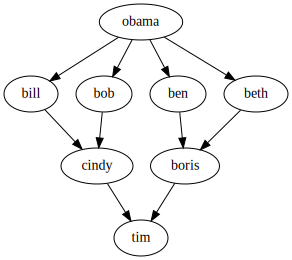

In [5]:
# 等待20秒以查看显示结果cpal_chain.draw(path="web.svg")  # 将cpal_chain对象绘制成SVG文件，保存为web.svgSVG("web.svg")  # 在Jupyter Notebook中显示web.svg文件的内容

### 无法回答的数学问题要点：PAL产生幻觉，而CPAL则不是产生幻觉，而是回答“无法回答的，叙述性问题和情节不连贯”。

In [6]:
问题 = (    "Jan有Marcia的宠物数量的三倍。"    "Marcia比Cindy多两只宠物。"    "如果Cindy有十只宠物，Barak有多少只宠物？")

In [7]:
# 运行 pal_chain 的 run 方法，并传入 question 参数pal_chain.run(question)这行代码调用了 `pal_chain` 对象的 `run` 方法，并将 `question` 参数传递给该方法。



> Entering new  chain...
def solution():
    """Jan has three times the number of pets as Marcia.Marcia has two more pets than Cindy.If Cindy has ten pets, how many pets does Barak have?"""
    cindy_pets = 10
    marcia_pets = cindy_pets + 2
    jan_pets = marcia_pets * 3
    result = jan_pets
    return result

> Finished chain.


'36'

In [8]:
# 尝试运行 cpal_chain，并捕获可能的异常try:    cpal_chain.run(question)  # 运行 cpal_chainexcept Exception as e_msg:  # 捕获任何异常并将其存储在变量 e_msg 中    print(e_msg)  # 打印异常消息



> Entering new  chain...
story outcome data
     name                            code  value depends_on
0   cindy                            pass   10.0         []
1  marcia  marcia.value = cindy.value + 2   12.0    [cindy]
2     jan    jan.value = marcia.value * 3   36.0   [marcia]

query data
{
    "question": "how many pets does barak have?",
    "expression": "SELECT name, value FROM df WHERE name = 'barak'",
    "llm_error_msg": ""
}

unanswerable, query and outcome are incoherent

outcome:
     name                            code  value depends_on
0   cindy                            pass   10.0         []
1  marcia  marcia.value = cindy.value + 2   12.0    [cindy]
2     jan    jan.value = marcia.value * 3   36.0   [marcia]
query:
{'question': 'how many pets does barak have?', 'expression': "SELECT name, value FROM df WHERE name = 'barak'", 'llm_error_msg': ''}


### 基本数学#### 因果中介者

In [9]:
问题 = (    "Jan有Marcia的宠物数量的三倍。"    "Marcia比Cindy多两只宠物。"    "如果Cindy有四只宠物，这三个人总共有多少只宠物？")

PAL是“Phase Alternating Line”的缩写，是一种视频编码系统，用于将彩色视频信号转换为模拟电视信号。PAL系统在欧洲、澳大利亚和一些亚非国家中被广泛采用。

In [10]:
# 运行pal_chain对象的run方法，并传入question作为参数pal_chain.run(question)



> Entering new  chain...
def solution():
    """Jan has three times the number of pets as Marcia. Marcia has two more pets than Cindy. If Cindy has four pets, how many total pets do the three have?"""
    cindy_pets = 4
    marcia_pets = cindy_pets + 2
    jan_pets = marcia_pets * 3
    total_pets = cindy_pets + marcia_pets + jan_pets
    result = total_pets
    return result

> Finished chain.


'28'

CPAL是一个开源软件许可证，全称为Common Public Attribution License（公共署名许可证）。

In [11]:
# 运行 cpal_chain 函数并传入 question 参数cpal_chain.run(question)



> Entering new  chain...
story outcome data
     name                            code  value depends_on
0   cindy                            pass    4.0         []
1  marcia  marcia.value = cindy.value + 2    6.0    [cindy]
2     jan    jan.value = marcia.value * 3   18.0   [marcia]

query data
{
    "question": "how many total pets do the three have?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


28.0

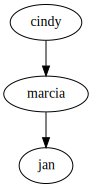

In [12]:
# 等待20秒以查看显示# 绘制cpal_chain，并保存为web.svg文件cpal_chain.draw(path="web.svg")# 显示web.svg文件中的内容SVG("web.svg")

### 因果碰撞器

In [13]:
问题 = (    "Jan拥有的宠物数量等于Marcia的宠物数量加上Cindy的宠物数量。"    "Marcia没有宠物。"    "如果Cindy有四只宠物，这三个人一共有多少只宠物？")# 输出问题print(问题)

In [14]:
# 运行cpal_chain的run方法，并传入question作为参数cpal_chain.run(question)



> Entering new  chain...
story outcome data
     name                                    code  value       depends_on
0  marcia                                    pass    0.0               []
1   cindy                                    pass    4.0               []
2     jan  jan.value = marcia.value + cindy.value    4.0  [marcia, cindy]

query data
{
    "question": "how many total pets do the three have?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


8.0

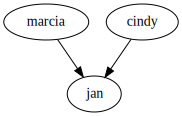

In [15]:
# 等待20秒以查看显示结果cpal_chain.draw(path="web.svg")  # 将cpal_chain对象绘制成SVG格式的图像，并保存为web.svg文件SVG("web.svg")  # 在Jupyter Notebook中显示web.svg文件的内容

### 因果混杂因素

In [16]:
问题 = (    "Jan有的宠物数量等于Marcia的宠物数量加上Cindy的宠物数量。"    "Marcia比Cindy多两只宠物。"    "如果Cindy有四只宠物，这三个人总共有多少只宠物？")

In [17]:
# 运行 cpal_chain 的 run 方法，并传入 question 参数cpal_chain.run(question)这段代码调用了 `cpal_chain` 对象的 `run` 方法，并将 `question` 参数传递给该方法。



> Entering new  chain...
story outcome data
     name                                    code  value       depends_on
0   cindy                                    pass    4.0               []
1  marcia          marcia.value = cindy.value + 2    6.0          [cindy]
2     jan  jan.value = cindy.value + marcia.value   10.0  [cindy, marcia]

query data
{
    "question": "how many total pets do the three have?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


20.0

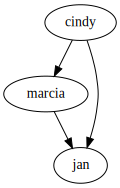

In [18]:
# 等待20秒以查看显示cpal_chain.draw(path="web.svg")  # 将cpal_chain对象绘制为SVG文件，保存为web.svgSVG("web.svg")  # 在Jupyter Notebook中显示web.svg文件的内容

In [19]:
# 加载autoreload扩展，使得在代码修改后自动重新加载模块%load_ext autoreload# 设置autoreload模式为2，即在执行代码前自动重新加载所有模块%autoreload 2